## 1. Simulate a noisy version of the image using the noises at various SNR Level (0 db, 10 dB and 20 dB)

By Diyun Lu and Yihan Zhong

In [ ]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fftshift, fft, fft2, ifft2
import scipy.signal
import math
import os
from scipy.signal import gaussian
from skimage.restoration import denoise_wavelet
import pywt

In [ ]:
!unzip '/content/nt_toolbox.zip'

In [ ]:
from __future__ import division
from nt_toolbox.general import *
from nt_toolbox.signal import *
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fft2', 'pylab', 'ifft2', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


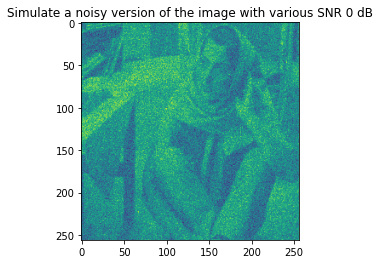

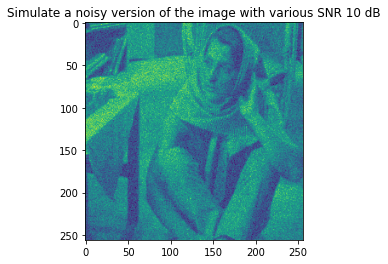

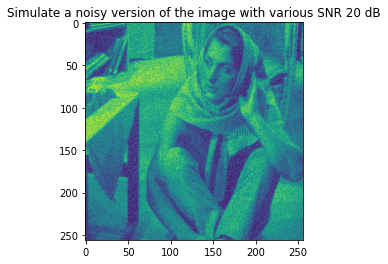

<Figure size 432x288 with 0 Axes>

In [ ]:
def add_noise(img, snr):

    # calculate sigma using snr
    sigma = np.sqrt(np.var(img)/pow(10, snr/20))

    # Generate the noise
    noise = np.random.normal(0, sigma, np.shape(img))
    img = img + noise

    # return the new signal with noise
    return img,sigma


def normalize_images(data):
    normalized_img = (data-np.min(data)) / (np.max(data)-np.min(data))
    return normalized_img


n = 256
name = '/content/barbara.jpg'
img = load_image(name, n)
snr_list = [0, 10, 20]
for snr in snr_list:
  plt.imshow(add_noise(img, snr)[0])
  plt.title("Simulate a noisy version of the image with various SNR {} dB".format(snr))
  plt.figure()

## 2. Denoise the image by performing hard thresholding and soft thresholding in the wavelet domain

### Hard Thresholding in Wavelet Bases

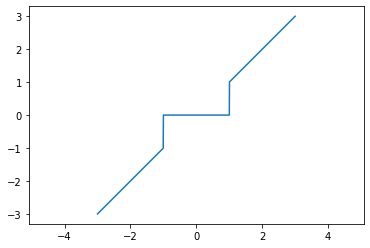

In [ ]:
def thresh_hard(u,t):
  return u*(abs(u)>t)
alpha = np.linspace(-3,3,1000)
plt.plot(alpha, thresh_hard(alpha,1))
plt.axis('equal');

Parameters for the orthogonal wavelet transform.

In [ ]:
data=add_noise(normalize_images(img), 10)[0]
sigma=add_noise(normalize_images(img), 10)[1]

In [ ]:
data.shape

(256, 256)

Parameters for the orthogonal wavelet transform.

In [ ]:
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
h = h/norm(h)
Jmin = 2

First we compute the wavelet coefficients a
of the noisy image f.

In [ ]:
a = perform_wavortho_transf(data,Jmin,+1,h)

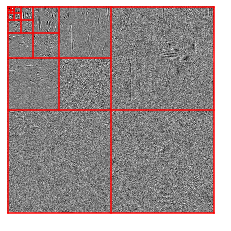

In [ ]:
plot_wavelet(a,Jmin);

Select the threshold value, that should be proportional to the noise level σ.

In [ ]:
T = 3*sigma

Hard threshold the coefficients below the noise level to obtain aT(m)=s0T(am).

In [ ]:
aT = thresh_hard(a,T)

Display the thresholded coefficients.

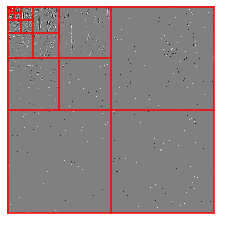

In [ ]:
plot_wavelet(aT,Jmin);

Reconstruct the image f̃  from these noisy coefficients.

In [ ]:
fHard = perform_wavortho_transf(aT,Jmin,-1,h)

Display the denoising result.

In [ ]:
def snr (x,y):
  return 20 * np.log10(pylab.norm(x) / pylab.norm(x - y))


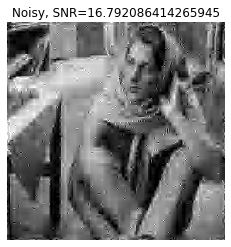

In [ ]:
imageplot(clamp(fHard),'Noisy, SNR=' + str(20 * np.log10(pylab.norm(img) / pylab.norm(img - fHard))))

### Wavelet Denoising with Soft Thesholding


The estimated image f̃  using hard thresholding. suffers from many artifacts. It is possible to improve the result by using soft thresholding, defined as
f̃ =S1T(f)=∑ms1T(⟨f,ψm⟩)ψm
wheres1T(α)=max(0,1−T|α|)α.
Display the soft thresholding function s1T(α).

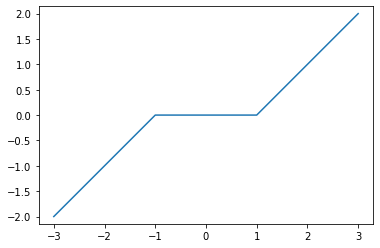

In [ ]:
def thresh_soft(u,t):
  return maximum(1-t/abs(u), 0)*u
alpha = linspace(-3,3,1000)
plot(alpha, thresh_soft(alpha,1))
axis('equal');

Select the threshold.

In [ ]:
T = 3/2*sigma

Perform the soft thresholding.

In [ ]:
aT = thresh_soft(a,T)

To slightly improve the soft thresholding performance, we do not threshold the coefficients corresponding to coarse scale wavelets.

In [ ]:
aT[:2^Jmin:,:2^Jmin:] = a[:2^Jmin:,:2^Jmin:]

Re-construct the soft thresholding estimator f̃ .

In [ ]:
fSoft = perform_wavortho_transf(aT,Jmin,-1,h)

Display the soft thresholding denoising result.

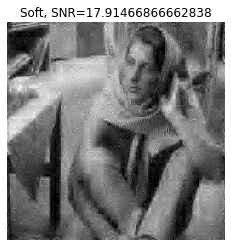

In [ ]:
imageplot(clamp(fSoft), 'Soft, SNR=' + str(20 * np.log10(pylab.norm(img) / pylab.norm(img - fSoft))) )


One can prove that if the non-linear approximation error ‖f0−ST(f0)‖2 decays fast toward zero when T decreases, then the quadratic risk 𝔼w(‖f−ST(f)‖2) also decays fast to zero when σ decays. For this result to hold, it is required to select the threshold value according to the universal threshold rule
T=σ2log(N)‾‾‾‾‾‾‾‾√.
Determine the best threshold T for both hard and soft thresholding. Test several (T) values in [.8σ,4.5σ[, and display the empirical SNR −10log10(‖f0−f̃ ‖/‖f0‖) What can you conclude from these results ? Test with another image.

# The parameters

The thresholding is based on a value λ that is
used to compare with all the detailed coefficients.
There are two types of thresholding, the hard and the
soft method. 

Hard thresholding is the process of setting coefficients whose absolute value is below a threshold lambda to zero. Soft thresholding is another method that first sets the parameter whose absolute value is below the threshold lambda to zero, and then shrinks the non-zero parameter to zero. Hard thresholding provides better edge preservation in comparison with the soft thresholding but soft
thresholding provides smoother results.

There are different types of Wavelet: Continuous Wavelet Transform, Discrete Wavelet Transform, and Multiresolution Analysis.

### Testing multiple thresholds for hard threshold and soft threshold

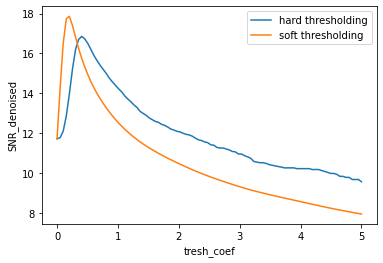

the best threshold coeeficient for soft thresholding is 0.20


In [ ]:
threshold_list=linspace(0,5,100)
snr_hard=[]
snr_soft=[]
img=img

for threshold in threshold_list: 
  a = perform_wavortho_transf(data,Jmin,+1,h)
  #hard_threshold
  aT_hard = thresh_hard(a,threshold)
  fHard = perform_wavortho_transf(aT_hard,Jmin,-1,h)
  snr_hard.append(20 * np.log10(pylab.norm(img) / pylab.norm(img - fHard)))

  aT_soft = thresh_soft(a,threshold)
  aT_soft[:2^Jmin:,:2^Jmin:] = a[:2^Jmin:,:2^Jmin:]
  fSoft = perform_wavortho_transf(aT_soft,Jmin,-1,h)
  snr_soft.append(20 * np.log10(pylab.norm(img) / pylab.norm(img - fSoft)))

# plot SNR vs. threshold  for both soft thresholding and hard thresholding
plt.plot(threshold_list, snr_hard, label="hard thresholding")
plt.plot(threshold_list, snr_soft, label="soft thresholding")
plt.legend(loc="upper right")
plt.xlabel("tresh_coef")
plt.ylabel("SNR_denoised")
plt.show()

print(f'the best threshold coeeficient for soft thresholding is {threshold_list[np.array(snr_soft).argmax()]:.2f}')


In [ ]:
print(f'the best threshold coeeficient for soft thresholding is {threshold_list[np.array(snr_soft).argmax()]:.2f}')

the best threshold coeeficient for soft thresholding is 0.20


From the plot, we can observe that the soft thresholding have better denoising effect, the best denoising threshold for soft thresholding is around 0.2.

### Testing with multiple Jmin (level of wavelet)

The number of level is the decomposition level, The maximum number of levels Jmax with which a signal can be decomposed, can be determined using the following equation :
Jmax= fix(log2[(N/Nw)-1])
N is the length of the signal, Nw gives the length of the decomposition filter associated with the chosen mother wavelet and fix is to round the value in the brackets to its nearest integer. 

If a sampling frequency of a given signal is 1024 samples/sec, you will get 5 levels, the frequency band corresponding to this sampling frequency is from -512 to 512. Let's as usual neglect the negative part for real signals. The first level trend contains 0..256, the detail 512..256. The second level trend then contains the frequencies 0..128, the second level details 256..128. Etc.


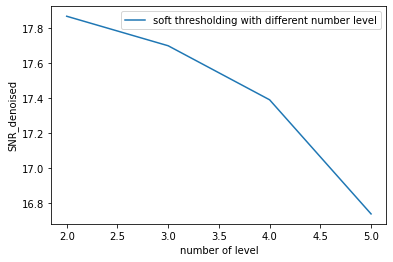

In [ ]:
Jmin_list=[2,3,4,5]
threshold=0.2
snr_list=[]

for Jmin in Jmin_list: 
  a = perform_wavortho_transf(data,Jmin,+1,h)

  aT_soft = thresh_soft(a,threshold)
  aT_soft[:2^Jmin:,:2^Jmin:] = a[:2^Jmin:,:2^Jmin:]
  fSoft = perform_wavortho_transf(aT_soft,Jmin,-1,h)
  snr_list.append(20 * np.log10(pylab.norm(img) / pylab.norm(img - fSoft)))

# plot SNR vs. threshold  for both soft thresholding and hard thresholding
plt.plot(Jmin_list, snr_list, label="soft thresholding with different number level")
plt.legend(loc="upper right")
plt.xlabel("number of level")
plt.ylabel("SNR_denoised")
plt.show()




From the output we observe that with a decompose level of two, the denoising effect is best.

## Translation Invariant Denoising with Cycle Spinning

Orthogonal wavelet transforms are not translation invariant. It means that the processing of an image and of a translated version of the image give different results.

Any denoiser can be turned into a translation invariant denoiser by performing a cycle spinning. The denoiser is applied to several shifted copies of the image, then the resulting denoised image are shifted back to the original position, and the results are averaged.

This corresponds to defining the estimator as
f̃ =1M∑i=1M$T−δi∘ST(f)∘Tδi
where ST is either the hard or soft thresholding, and Tδ(f)(x)=f(x−δ) is the translation operator, using periodic boundary conditions. Here (δi)i is a set of M discrete translation. Perfect invariance is obtained by using all possible N translatation, but usually a small number M≪N of translation is used to obtain approximate invariance.

Number m of translations along each direction so that M=m2.

In [ ]:
data=add_noise(normalize_images(img), 10)[0]
sigma=add_noise(normalize_images(img), 10)[1]

In [ ]:
m = 4

Generate a set of shifts (δi)i.

In [ ]:
[dY,dX] = meshgrid(arange(0,m),arange(0,m))
delta = concatenate( (dX.reshape(m*m,1), dY.reshape(m*m,1)), axis=1)

To avoid storing all the translates in memory, one can perform a progressive averaging of the translates by defining f(0)=0 and then
∀i=1,…,M,f(i)=(1−in)f(i−1)+inT−δi∘ST(f)∘Tδi
One then has f̃ =f(M) after M steps.

Initialize the denoised image f(0)=0.

In [ ]:
def Invariant_Denoising(data,Jmin,T):
  fTI = zeros([n,n])
  #T = 3*sigma
  for i in arange(0,m*m):
      fS = circshift(data,delta[i,:])
      a = perform_wavortho_transf(fS,Jmin,1,h)
      aT = thresh_hard(a,T)
      fS = perform_wavortho_transf(aT,Jmin,-1,h)
      fS = circshift(fS,-delta[i,:])
      fTI = i/(i+1.0)*fTI + 1.0/(i+1)*fS
  return fTI

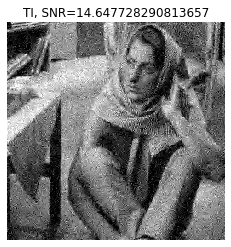

In [ ]:
fTI=Invariant_Denoising(data,Jmin,T)
imageplot(clamp(fTI), 'TI, SNR=' + str(20 * np.log10(pylab.norm(img) / pylab.norm(img - fTI))) )

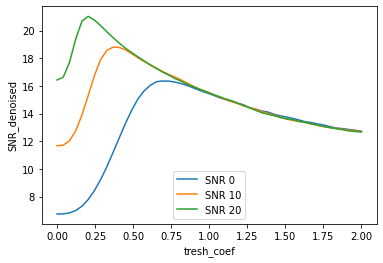

In [ ]:
threshold_list=np.linspace(0,2,50)
snr_level=[0,10,20]
noise_img_list=[]
noise_img_dict={snr:[] for snr in snr_level}
for snr in snr_level:
  data=add_noise(normalize_images(img), snr)[0]
  noise_img_list.append(data)
  noise_img_dict[snr]=data

for snr in snr_level:
  data=noise_img_dict[snr]
  snr_list=[]
  for threshold in threshold_list:
    img_denoised=Invariant_Denoising(data,2,threshold)
    snr_denoised=20 * np.log10(pylab.norm(img) / pylab.norm(img - img_denoised))
    snr_list.append(snr_denoised)
  plt.plot(threshold_list,snr_list,label=f'SNR {snr}')

plt.legend(loc="lower center")
plt.xlabel("tresh_coef")
plt.ylabel("SNR_denoised")
plt.show()


From the curve, we can observe that the lower the snr is, the larger the threshold coefficient we need to choose.